# B.1.1.529 variant analysis

The B.1.1.529 (AKA omicron) has raised concerns due to its high number of mutations combining mutations from the alpha and delta lineages with new mutations.

Here we aim at understanding its potential impact in an escape from the immunity from the vaccine and from previous strains.

## B.1.1.529 spike protein sequence

Unfortunately, we do not have access to GISAID now, but we have the list of omicron mutations in the spike protein from a reliable source, Pango designation repository.

From here https://github.com/cov-lineages/pango-designation/issues/343 we fetch the mutations in the spike protein. These are:

A67V, Δ69-70, T95I, G142D/Δ143-145, Δ211/L212I, ins214EPE, G339D, S371L, S373P, S375F, K417N, N440K, G446S, S477N, T478K, E484A, Q493K, G496S, Q498R, N501Y, Y505H, T547K, D614G, H655Y, N679K, P681H, N764K, D796Y, N856K, Q954H, N969K, L981F

We obtain the sequence of spike protein in the omicron lineage by applying these mutations to the reference genome.

In [1]:
from Bio import SeqIO, Align
from Bio.Seq import Seq, IUPAC
from Bio.Alphabet import ProteinAlphabet
from logzero import logger
import pandas as pd
import requests
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook")
import numpy as np
sns.set_style("whitegrid")
sns.color_palette("colorblind")
import time
from multiprocessing import  Pool
import random

In [2]:
reference_fasta = "../../references/Sars_cov_2.ASM985889v3.cds.all.fa"
spike_dna = None
for record in SeqIO.parse(reference_fasta, "fasta"):
    if "gene_symbol:S" in record.description:
        spike_dna = record
print(spike_dna.seq)

ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACAA

In [3]:
spike_protein = spike_dna.translate()
print(spike_protein.seq)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

In [4]:
def apply_mutation(sequence, position, reference, alternate):
    logger.info("Applying mutation {}:{}>{}".format(position, reference, alternate))
    if len(reference) == 1 and len(alternate) == 1:
        ## SNV
        assert reference == sequence[position - 1], "Not matching to reference"
        return sequence[0:position - 1] + alternate + sequence[position:], 0
    if len(alternate) == 0:
        ## deletion
        assert reference == str(sequence[position - 1: position - 1 + len(reference)].seq), "Not matching to reference: {}".format(
            str(sequence[position - 1: position - 1 + len(reference)].seq))
        return sequence[0:position - 1] + alternate + sequence[position + len(reference) - 1 : ], - len(reference)
    if len(reference) == 0:
        ## insertion
        return sequence[0:position - 1] + alternate + sequence[position - 1 : ], len(alternate)

def apply_mutations(protein, mutations):
    offset = 0
    for p, r, a in mutations:
        protein, mutation_offset = apply_mutation(protein, position=p + offset, reference=r, alternate=a)
        offset = offset + mutation_offset
    return protein

In [5]:
omicron_mutations = [
    (67, "A", "V"),             #A67V
    (69, "HV", ""),             #Δ69-70, 
    (95, "T", "I"),             #T95I, 
    (142, "G", "D"),            #G142D
    (143, "VYY", ""),           #Δ143-145, 
    (211, "N", ""),             #Δ211
    (212, "L", "I"),            #L212I, 
    (214, "", "EPE"),           #ins214EPE, 
    (339, "G", "D"),            #G339D, 
    (371, "S", "L"),            #S371L, 
    (373, "S", "P"),            #S373P, 
    (375, "S", "F"),            #S375F, 
    (417, "K", "N"),            #K417N, 
    (440, "N", "K"),            #N440K, 
    (446, "G", "S"),            #G446S, 
    (477, "S", "N"),            #S477N, 
    (478, "T", "K"),            #T478K, 
    (484, "E", "A"),            #E484A, 
    (493, "Q", "K"),            #Q493K, 
    (496, "G", "S"),            #G496S, 
    (498, "Q", "R"),            #Q498R, 
    (501, "N", "Y"),            #N501Y, 
    (505, "Y", "H"),            #Y505H, 
    (547, "T", "K"),            #T547K, 
    (614, "D", "G"),            #D614G, 
    (655, "H", "Y"),            #H655Y,
    (679, "N", "K"),            #N679K, 
    (681, "P", "H"),            #P681H, 
    (764, "N", "K"),            #N764K, 
    (796, "D", "Y"),            #D796Y, 
    (856, "N", "K"),            #N856K, 
    (954, "Q", "H"),            #Q954H, 
    (969, "N", "K"),            #N969K, 
    (981, "L", "F")             #L981F
]

omicron_apike_protein = apply_mutations(protein=spike_protein, mutations=omicron_mutations)
print(omicron_apike_protein.seq)

[I 211129 23:13:24 4276497315:2] Applying mutation 67:A>V
[I 211129 23:13:24 4276497315:2] Applying mutation 69:HV>
[I 211129 23:13:24 4276497315:2] Applying mutation 93:T>I
[I 211129 23:13:24 4276497315:2] Applying mutation 140:G>D
[I 211129 23:13:24 4276497315:2] Applying mutation 141:VYY>
[I 211129 23:13:24 4276497315:2] Applying mutation 206:N>
[I 211129 23:13:24 4276497315:2] Applying mutation 206:L>I
[I 211129 23:13:24 4276497315:2] Applying mutation 208:>EPE
[I 211129 23:13:24 4276497315:2] Applying mutation 336:G>D
[I 211129 23:13:24 4276497315:2] Applying mutation 368:S>L
[I 211129 23:13:24 4276497315:2] Applying mutation 370:S>P
[I 211129 23:13:24 4276497315:2] Applying mutation 372:S>F
[I 211129 23:13:24 4276497315:2] Applying mutation 414:K>N
[I 211129 23:13:24 4276497315:2] Applying mutation 437:N>K
[I 211129 23:13:24 4276497315:2] Applying mutation 443:G>S
[I 211129 23:13:24 4276497315:2] Applying mutation 474:S>N
[I 211129 23:13:24 4276497315:2] Applying mutation 475:T>K

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHVISGTNGTKRFDNPVLPFNDGVYFASIEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPIIVEPERDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLKSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLKGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEYVNNSYECDIPIGAGICASYQTQTKSHRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLKRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKYFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFKGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNHNAQALNTLVKQLSSKFGAISSVLNDIFSRLDKVEAEVQIDRLITGRLQS

## B.1.617.2 (delta) spike protein sequence

We obtain the spike mutations in the B.1.617.2 lineage from here: https://github.com/cov-lineages/constellations/blob/main/constellations/definitions/cB.1.617.2.json

These are:
T19R, G142D, L452R, T478K, P681R, D950N

We need to add in the mutation D614G shared by alpha, beta, gamma, delta and omicron.

Also, from above the deletion 22028:GAGTTCA>G is missing. This translates at the aminoacid level in two mutations E156G and Δ157-158

In [6]:
delta_mutations = [
    (19, "T", "R"),            # T19R
    (142, "G", "D"),           # G142D
    (156, "E", "G"),           # E156G
    (157, "FR", ""),           # Δ157-158
    (452, "L", "R"),           # L452R 
    (478, "T", "K"),           # T478K
    (614, "D", "G"),           # T478K
    (681, "P", "R"),           # P681R 
    (950, "D", "N")            # D950N
]

delta_spike_protein = apply_mutations(protein=spike_protein, mutations=delta_mutations)
print(delta_spike_protein.seq)

[I 211129 23:13:24 4276497315:2] Applying mutation 19:T>R
[I 211129 23:13:24 4276497315:2] Applying mutation 142:G>D
[I 211129 23:13:24 4276497315:2] Applying mutation 156:E>G
[I 211129 23:13:24 4276497315:2] Applying mutation 157:FR>
[I 211129 23:13:24 4276497315:2] Applying mutation 450:L>R
[I 211129 23:13:24 4276497315:2] Applying mutation 476:T>K
[I 211129 23:13:24 4276497315:2] Applying mutation 612:D>G
[I 211129 23:13:24 4276497315:2] Applying mutation 679:P>R
[I 211129 23:13:24 4276497315:2] Applying mutation 948:D>N


MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQGVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQNVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQ

## Epitopes

Given the two spike protein sequences we aim at understanding how the set of epitopes from each of these proteins may be recognised differently by the immune system.

We download from IEDB 1502 linear epitopes from SARS-CoV-2 spike glycoprotein with positive outcome for T-cell or MHC binding on 26/11/2021. Of these only 1500 have an exact match with the reference; but only 1437 have an exact match with the B.1.1.529 spike protein. For the remaining 64 epitopes without an exact match in B.1.1.529 we perform a global alignment and fetch the closest sequences.

In [7]:
epitopes = pd.read_csv("epitope_table_export_1637963222.csv", sep=",", skiprows=1)
epitopes = epitopes[epitopes["Object Type"] == "Linear peptide"]
epitopes["epitope"] = epitopes.Description.transform(lambda e: e.split(" ")[0])
epitopes.head()

,Epitope IRI,Object Type,Description,Epitope Modified Residue(s),Epitope Modification(s),Starting Position,Ending Position,Non-peptidic epitope IRI,Epitope Synonyms,Antigen Name,...,Synonyms,Antigen Name.1,Antigen IRI.1,Parent Protein.1,Parent Protein IRI.1,Organism Name.1,Organism IRI.1,Parent Organism.1,Parent Organism IRI.1,epitope
0,http://www.iedb.org/epitope/1220,Linear peptide,AEVQIDRLI,NaN,NaN,989.0,997.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AEVQIDRLI
1,http://www.iedb.org/epitope/2801,Linear peptide,ALNTLVKQL,NaN,NaN,958.0,966.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALNTLVKQL
2,http://www.iedb.org/epitope/3589,Linear peptide,APHGVVFLHV,NaN,NaN,1056.0,1065.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APHGVVFLHV
3,http://www.iedb.org/epitope/6668,Linear peptide,CMTSCCSCLK,NaN,NaN,1236.0,1245.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CMTSCCSCLK
4,http://www.iedb.org/epitope/7247,Linear peptide,CVADYSVLY,NaN,NaN,361.0,369.0,NaN,NaN,surface glycoprotein [Severe acute respiratory...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CVADYSVLY


In [8]:
epitopes.shape

(1502, 34)

In [116]:
def get_alignment(sequence, epitope):
    alignment = None
    aligner = Align.PairwiseAligner()
    aligner.mode = 'global'
    aligner.match = 2
    aligner.mismatch = -2
    aligner.open_gap_score = -3
    aligner.extend_gap_score = -1
    aligner.target_end_gap_score = 0.0
    aligner.query_end_gap_score = 0.0
    try:
        alignment = aligner.align(sequence, epitope)
    except ValueError as e:
        logger.error(epitope)
        logger.error(e)
    return alignment


def has_exact_match(sequence, epitope):
    exact_match = False
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        exact_match = len(alignment.aligned[1]) == 1 and alignment.query == alignment.target[alignment.aligned[0][0][0] : alignment.aligned[0][0][1]]
        #logger.info(alignment.aligned[0])
        #logger.info(alignment.aligned[1])
    return exact_match


def get_closest_match(sequence, epitope):
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        start, _ = min(alignment.aligned[0])
        _, end = max(alignment.aligned[0])
    return str(sequence[start:end])

In [117]:
epitopes["has_exact_match_reference"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=spike_protein.seq[0:-1], epitope=e))
epitopes["has_exact_match_omicron"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))
epitopes["has_exact_match_delta"] = epitopes.epitope.transform(lambda e: has_exact_match(sequence=delta_spike_protein.seq[0:-1], epitope=e))

In [115]:
alignment = get_alignment(sequence=delta_spike_protein.seq[0:-1], epitope="EFQFCNDPFLGVYYH")
print(alignment[0].query)
print(alignment[0].target[alignment[0].aligned[0][0][0] : alignment[0].aligned[0][0][1]])
print(alignment[0].aligned[0][0])

EFQFCNDPFLGVYYH
EFQFCNDPFLDVYYH
(131, 146)


In [118]:
epitopes.has_exact_match_reference.sum()

1454

In [119]:
epitopes.has_exact_match_omicron.sum()

1059

In [120]:
epitopes.has_exact_match_delta.sum()

1286

In [189]:
epitopes[(~epitopes.has_exact_match_delta) & (epitopes.has_exact_match_reference) & (~epitopes.has_exact_match_omicron)].shape

(121, 37)

In [121]:
omicron_epitopes = epitopes[(~epitopes.has_exact_match_omicron) & (epitopes.has_exact_match_reference)]
omicron_epitopes.shape

(396, 37)

In [122]:
delta_epitopes = epitopes[(~epitopes.has_exact_match_delta) & (epitopes.has_exact_match_reference)]
delta_epitopes.shape

(169, 37)

In [123]:
omicron_epitopes["homologous_epitope"] = omicron_epitopes.epitope.transform(lambda e: get_closest_match(sequence=omicron_apike_protein.seq[0:-1], epitope=e))
omicron_epitopes[["epitope", "homologous_epitope"]].head(10)

,epitope,homologous_epitope
8,GSFCTQLNR,GSFCTQLKR
19,LQDVVNQNAQALNTL,LQDVVNHNAQALNTL
35,SVLNDILSR,SVLNDIFSR
38,VLNDILSRL,VLNDIFSRL
44,FPNITNLCPFGEVFN,FPNITNLCPFDEVFN
46,NFGAISSVLNDILSR,KFGAISSVLNDIFSR
50,CVADYSVLYNSASFS,CVADYSVLYNLAPFF
51,DDFTGCVIAWNSNNL,DDFTGCVIAWNSNKL
55,FNFNGLTGTGVLTES,FNFNGLKGTGVLTES
60,KNKCVNFNFNGLTGT,KNKCVNFNFNGLKGT


In [124]:
delta_epitopes["homologous_epitope"] = delta_epitopes.epitope.transform(lambda e: get_closest_match(sequence=delta_spike_protein.seq[0:-1], epitope=e))
delta_epitopes[["epitope", "homologous_epitope"]].head(10)

,epitope,homologous_epitope
19,LQDVVNQNAQALNTL,LQNVVNQNAQALNTL
82,VGGNYNYLYRLFRKS,VGGNYNYRYRLFRKS
85,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE
88,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS
100,FCNDPFLGVYY,FCNDPFLDVYY
122,KSWMESEFRVY,KSWMESGVY
124,KVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYV,KVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYV
129,LPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERD,LPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERD
138,NYNYLYRLFRK,NYNYRYRLFRK
151,SYQTQTNSPRRARSVA,SYQTQTNSRRRARSVA


## Overlapping mutations

In [153]:
def get_overlapping_mutations(sequence, epitope, mutations):
    alignments = get_alignment(sequence=sequence, epitope=epitope)
    if alignments is not None:
        alignment = alignments[0]
        start, _ = min(alignment.aligned[0])
        _, end = max(alignment.aligned[0])
    return list(map(lambda m: "{}{}{}".format(m[1], m[0], m[2]), filter(lambda x: x[0] - 2 >= start and x[0] - 2 <= end, mutations)))
        

In [154]:
alignments = get_alignment(sequence=omicron_apike_protein.seq[0:-1], epitope="GSFCTQLKR")
start, end = max(alignments[0].aligned[0])
print(start)
print(end)
omicron_apike_protein.seq[start:end]

753
762


Seq('GSFCTQLKR', HasStopCodon(ExtendedIUPACProtein(), '*'))

In [155]:
omicron_epitopes["overlapping_mutations"] = omicron_epitopes.epitope.transform(lambda e: get_overlapping_mutations(
    sequence=omicron_apike_protein.seq[0:-1], epitope=e, mutations=omicron_mutations))
omicron_epitopes[["epitope", "homologous_epitope", "overlapping_mutations"]]

,epitope,homologous_epitope,overlapping_mutations
8,GSFCTQLNR,GSFCTQLKR,[N764K]
19,LQDVVNQNAQALNTL,LQDVVNHNAQALNTL,[Q954H]
35,SVLNDILSR,SVLNDIFSR,[L981F]
38,VLNDILSRL,VLNDIFSRL,[L981F]
44,FPNITNLCPFGEVFN,FPNITNLCPFDEVFN,[G339D]
46,NFGAISSVLNDILSR,KFGAISSVLNDIFSR,"[N969K, L981F]"
50,CVADYSVLYNSASFS,CVADYSVLYNLAPFF,"[S371L, S373P]"
51,DDFTGCVIAWNSNNL,DDFTGCVIAWNSNKL,[N440K]
55,FNFNGLTGTGVLTES,FNFNGLKGTGVLTES,[T547K]
60,KNKCVNFNFNGLTGT,KNKCVNFNFNGLKGT,[T547K]


In [156]:
omicron_overlapping_mutations = omicron_epitopes[["epitope", "homologous_epitope", "overlapping_mutations"]].set_index(
    ["epitope", "homologous_epitope"])['overlapping_mutations'].apply(pd.Series).stack()
omicron_overlapping_mutations = omicron_overlapping_mutations.reset_index()
del omicron_overlapping_mutations["level_2"]
omicron_overlapping_mutations.rename(columns={0: "mutation"}, inplace=True)
omicron_overlapping_mutations.head()

,epitope,homologous_epitope,mutation
0,GSFCTQLNR,GSFCTQLKR,N764K
1,LQDVVNQNAQALNTL,LQDVVNHNAQALNTL,Q954H
2,SVLNDILSR,SVLNDIFSR,L981F
3,VLNDILSRL,VLNDIFSRL,L981F
4,FPNITNLCPFGEVFN,FPNITNLCPFDEVFN,G339D


In [157]:
omicron_overlapping_mutations.groupby("mutation").count().sort_values("epitope", ascending=False)

,epitope,homologous_epitope
mutation,,
N440K,43,43
S373P,38,38
S477N,38,38
T478K,37,37
S371L,36,36
S375F,32,32
G446S,31,31
N764K,29,29
VYY143,28,28


In [161]:
delta_epitopes["overlapping_mutations"] = delta_epitopes.epitope.transform(lambda e: get_overlapping_mutations(
    sequence=delta_spike_protein.seq[0:-1], epitope=e, mutations=delta_mutations))
delta_epitopes[["epitope", "homologous_epitope", "overlapping_mutations"]]

,epitope,homologous_epitope,overlapping_mutations
19,LQDVVNQNAQALNTL,LQNVVNQNAQALNTL,[D950N]
82,VGGNYNYLYRLFRKS,VGGNYNYRYRLFRKS,[L452R]
85,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,[L452R]
88,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,[P681R]
100,FCNDPFLGVYY,FCNDPFLDVYY,[G142D]
122,KSWMESEFRVY,KSWMESGVY,"[E156G, FR157]"
124,KVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYV,KVCEFQFCNDPFLDVYYHKNNKSWMESGVYSSANNCTFEYV,"[G142D, E156G, FR157]"
129,LPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERD,LPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERD,[L452R]
138,NYNYLYRLFRK,NYNYRYRLFRK,[L452R]
151,SYQTQTNSPRRARSVA,SYQTQTNSRRRARSVA,[P681R]


In [162]:
delta_overlapping_mutations = delta_epitopes[["epitope", "homologous_epitope", "overlapping_mutations"]].set_index(
    ["epitope", "homologous_epitope"])['overlapping_mutations'].apply(pd.Series).stack()
delta_overlapping_mutations = delta_overlapping_mutations.reset_index()
del delta_overlapping_mutations["level_2"]
delta_overlapping_mutations.rename(columns={0: "mutation"}, inplace=True)
delta_overlapping_mutations.head()

,epitope,homologous_epitope,mutation
0,LQDVVNQNAQALNTL,LQNVVNQNAQALNTL,D950N
1,VGGNYNYLYRLFRKS,VGGNYNYRYRLFRKS,L452R
2,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,L452R
3,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,P681R
4,FCNDPFLGVYY,FCNDPFLDVYY,G142D


In [163]:
delta_overlapping_mutations.groupby("mutation").count().sort_values("epitope", ascending=False)

,epitope,homologous_epitope
mutation,,
L452R,53,53
G142D,40,40
T478K,38,38
E156G,12,12
FR157,12,12
P681R,10,10
D950N,9,9
D614G,5,5
T19R,5,5


## Differential MHC I binding

Using NetMHCpan through IEDB tools we calculate the differential MHC binding between epitopes present in the reference spike protein and epitopes in B.1.1.529.

We use the top 5 HLA alleles in Europe fetched from http://www.allelefrequencies.net/top10freqsc.asp.

In [18]:
#session = requests.Session()

#def get_best_rank_mhc_binding(epitope, hla_allele='HLA-A*01:01', length=9):
#    retries = 0
#    success = False
#    while not success and retries <= 5:
#        response = session.post("http://tools-cluster-interface.iedb.org/tools_api/mhci/", 
#                                 data = {'method':'netmhcpan-4.1', 'sequence_text':epitope, 'allele':hla_allele,'length':length})
#        retries += 1
#        success = response.status_code == 200
#        if not success:
#            #N = (2 ** retries) - 1
#            #t = (1 / (N + 1)) * sum(range(N + 1))
#            #time.sleep(random.uniform(0, t))
#            #time.sleep(random.uniform(1, 2))
#            time.sleep(2)
#    if not success:
#        logger.info("Retries exhausted for {} on {}".format(epitope, hla_allele))
#    if success:
#        binding_results = pd.read_csv(StringIO(response.text), sep="\t")
#        #binding_results.to_csv("netmhcpan_results/{}_{}.csv".format(epitope, hla_allele.replace("*", "_").replace(":", "_")), index=False)
#        if "percentile_rank" in binding_results.columns:
#            return float(binding_results.percentile_rank.iloc[0]) ##, binding_results.peptide.iloc[0]
#    return None

In [164]:
import tempfile
import subprocess
netmhcpan = "/home/priesgo/neofox_install/netMHCpan-4.1/netMHCpan"

def get_best_rank_mhc_binding(epitope, hla_allele='HLA-A*01:01', length=9):
    
    rank = None
    
    tmp = tempfile.NamedTemporaryFile()

    # Open the file for writing.
    with open(tmp.name, 'w') as f:
        f.write(epitope) # where `stuff` is, y'know... stuff to write (a string)
    command = "{netmhcpan} -p {fasta} -a {hla_allele} -BA -s".format(
        netmhcpan=netmhcpan, fasta=tmp.name, hla_allele=hla_allele.replace("*", ""), epitope=epitope)
    
    process = subprocess.Popen(
            command.split(" "),
            stderr=subprocess.PIPE,
            stdout=subprocess.PIPE
        )
    output, errors = process.communicate()
    return_code = process.returncode
    for l in output.decode("utf8").split("\n"):
        if epitope in l:
            rank = list(filter(lambda x: x != "", l.split(" ")))[14]
            break
    return rank

In [20]:
get_best_rank_mhc_binding(epitope="SLYNTVATLYCVHQRIDV")

'23.661'

In [165]:
def parallelize_dataframe(df, func, n_cores=8):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def add_mhc_bindings(df):
    df["mhc_binding"] = df.epitope.transform(lambda e: get_best_rank_mhc_binding(epitope=e, hla_allele=df.hla_allele.iloc[0]))
    df["homologous_mhc_binding"] = df.homologous_epitope.transform(lambda e: get_best_rank_mhc_binding(epitope=e, hla_allele=df.hla_allele.iloc[0]))
    return df

def get_mhc_bindings(epitopes, hla_alleles):
    mhc_bindings = []
    start = time.time()
    for a in hla_alleles:
        logger.info("Processing allele {}".format(a))
        mhc_binding = epitopes.copy()
        mhc_binding["hla_allele"] = a
        mhc_binding = parallelize_dataframe(mhc_binding, add_mhc_bindings)
        mhc_bindings.append(mhc_binding)
    end = time.time()
    logger.info("Run time: {}".format(end - start))
    return pd.concat(mhc_bindings)

In [166]:
top5_european_hla_alleles = [
    "HLA-A*01:01",
    "HLA-A*02:01",
    "HLA-A*03:01",
    "HLA-A*11:01",
    "HLA-A*24:02",
    "HLA-B*07:02",
    "HLA-B*51:01",
    "HLA-B*08:01",
    "HLA-B*44:02",
    "HLA-B*35:01",
    "HLA-C*07:01",
    "HLA-C*04:01",
    "HLA-C*07:02",
    "HLA-C*06:02",
    "HLA-C*05:01"
]

In [167]:
delta_mhc_binding_europe = get_mhc_bindings(epitopes=delta_epitopes[["epitope", "homologous_epitope"]], hla_alleles=top5_european_hla_alleles)
delta_mhc_binding_europe.to_csv("epitopes_mhc_binding_delta_europe.csv", index=False)
delta_mhc_binding_europe.head()

[I 211130 01:00:20 4104880729:18] Processing allele HLA-A*01:01
[I 211130 01:00:46 4104880729:18] Processing allele HLA-A*02:01
[I 211130 01:01:12 4104880729:18] Processing allele HLA-A*03:01
[I 211130 01:01:40 4104880729:18] Processing allele HLA-A*11:01
[I 211130 01:02:10 4104880729:18] Processing allele HLA-A*24:02
[I 211130 01:02:38 4104880729:18] Processing allele HLA-B*07:02
[I 211130 01:03:09 4104880729:18] Processing allele HLA-B*51:01
[I 211130 01:03:39 4104880729:18] Processing allele HLA-B*08:01
[I 211130 01:04:10 4104880729:18] Processing allele HLA-B*44:02
[I 211130 01:04:40 4104880729:18] Processing allele HLA-B*35:01
[I 211130 01:05:10 4104880729:18] Processing allele HLA-C*07:01
[I 211130 01:05:44 4104880729:18] Processing allele HLA-C*04:01
[I 211130 01:06:16 4104880729:18] Processing allele HLA-C*07:02
[I 211130 01:06:50 4104880729:18] Processing allele HLA-C*06:02
[I 211130 01:07:21 4104880729:18] Processing allele HLA-C*05:01
[I 211130 01:07:52 4104880729:24] Run ti

,epitope,homologous_epitope,hla_allele,mhc_binding,homologous_mhc_binding
19,LQDVVNQNAQALNTL,LQNVVNQNAQALNTL,HLA-A*01:01,32.622,52.330
82,VGGNYNYLYRLFRKS,VGGNYNYRYRLFRKS,HLA-A*01:01,65.878,73.568
85,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,HLA-A*01:01,46.111,70.663
88,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,HLA-A*01:01,88.605,89.011
100,FCNDPFLGVYY,FCNDPFLDVYY,HLA-A*01:01,1.019,1.024


In [168]:
omicron_mhc_binding_europe = get_mhc_bindings(epitopes=omicron_epitopes[["epitope", "homologous_epitope"]], hla_alleles=top5_european_hla_alleles)
omicron_mhc_binding_europe.to_csv("epitopes_mhc_binding_omicron_europe.csv", index=False)
omicron_mhc_binding_europe.head()

[I 211130 01:07:52 4104880729:18] Processing allele HLA-A*01:01
[I 211130 01:09:11 4104880729:18] Processing allele HLA-A*02:01
[I 211130 01:10:27 4104880729:18] Processing allele HLA-A*03:01
[I 211130 01:11:43 4104880729:18] Processing allele HLA-A*11:01
[I 211130 01:13:01 4104880729:18] Processing allele HLA-A*24:02
[I 211130 01:14:20 4104880729:18] Processing allele HLA-B*07:02
[I 211130 01:15:38 4104880729:18] Processing allele HLA-B*51:01
[I 211130 01:16:54 4104880729:18] Processing allele HLA-B*08:01
[I 211130 01:18:12 4104880729:18] Processing allele HLA-B*44:02
[I 211130 01:19:32 4104880729:18] Processing allele HLA-B*35:01
[I 211130 01:20:51 4104880729:18] Processing allele HLA-C*07:01
[I 211130 01:22:08 4104880729:18] Processing allele HLA-C*04:01
[I 211130 01:23:26 4104880729:18] Processing allele HLA-C*07:02
[I 211130 01:24:42 4104880729:18] Processing allele HLA-C*06:02
[I 211130 01:26:01 4104880729:18] Processing allele HLA-C*05:01
[I 211130 01:27:21 4104880729:24] Run ti

,epitope,homologous_epitope,hla_allele,mhc_binding,homologous_mhc_binding
8,GSFCTQLNR,GSFCTQLKR,HLA-A*01:01,10.983,9.494
19,LQDVVNQNAQALNTL,LQDVVNHNAQALNTL,HLA-A*01:01,32.622,30.803
35,SVLNDILSR,SVLNDIFSR,HLA-A*01:01,40.101,40.721
38,VLNDILSRL,VLNDIFSRL,HLA-A*01:01,12.277,9.082
44,FPNITNLCPFGEVFN,FPNITNLCPFDEVFN,HLA-A*01:01,41.509,41.560


In [169]:
delta_mhc_binding_europe.mhc_binding = pd.to_numeric(delta_mhc_binding_europe.mhc_binding, downcast="float")
delta_mhc_binding_europe.homologous_mhc_binding = pd.to_numeric(delta_mhc_binding_europe.homologous_mhc_binding, downcast="float")
omicron_mhc_binding_europe.mhc_binding = pd.to_numeric(omicron_mhc_binding_europe.mhc_binding, downcast="float")
omicron_mhc_binding_europe.homologous_mhc_binding = pd.to_numeric(omicron_mhc_binding_europe.homologous_mhc_binding, downcast="float")

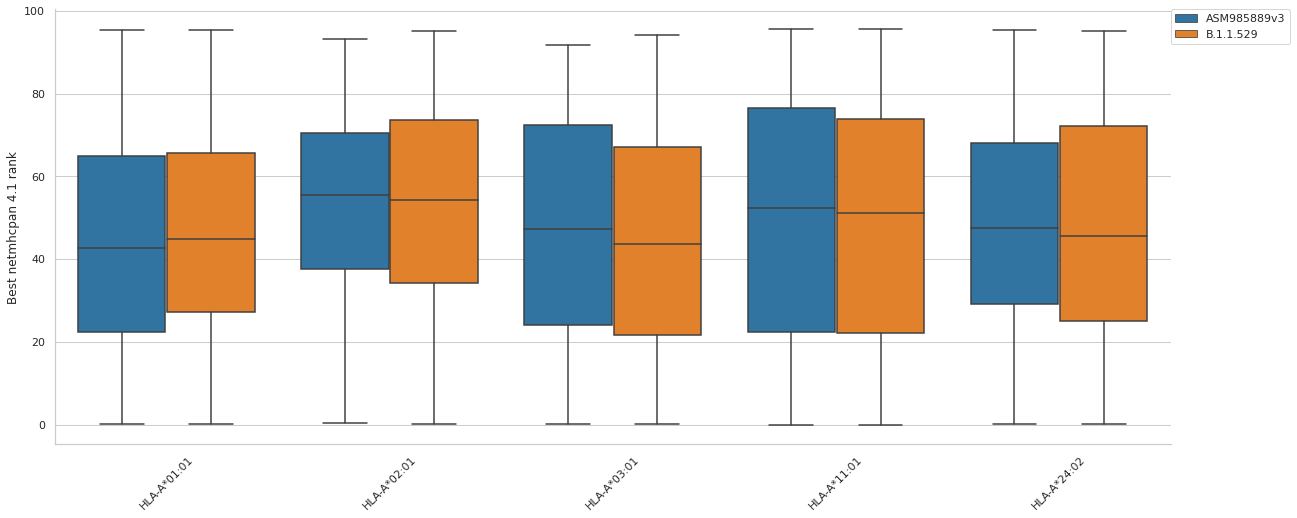

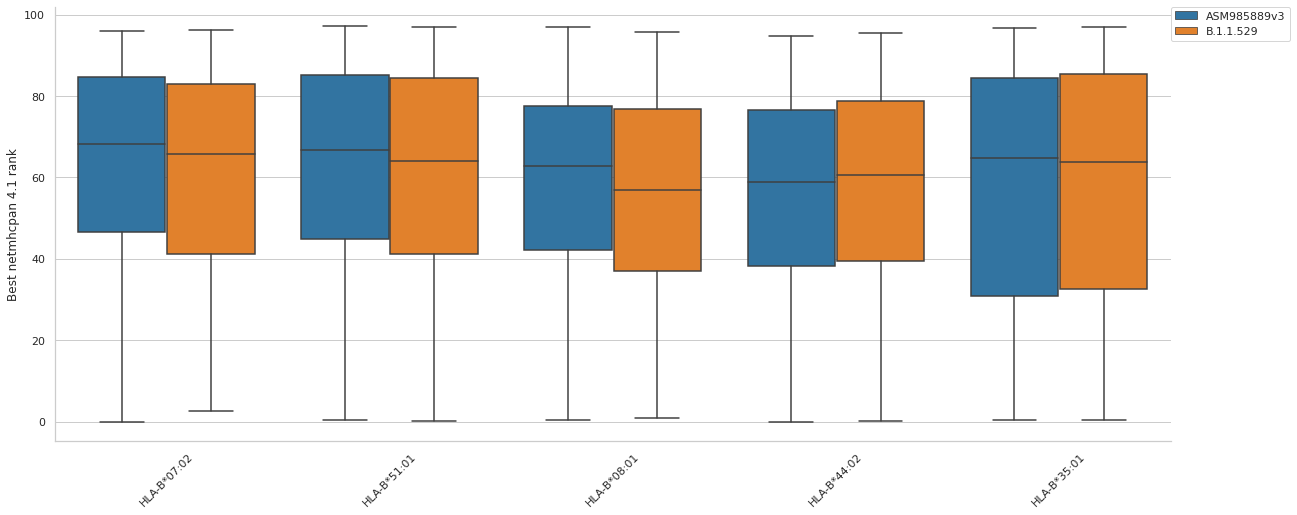

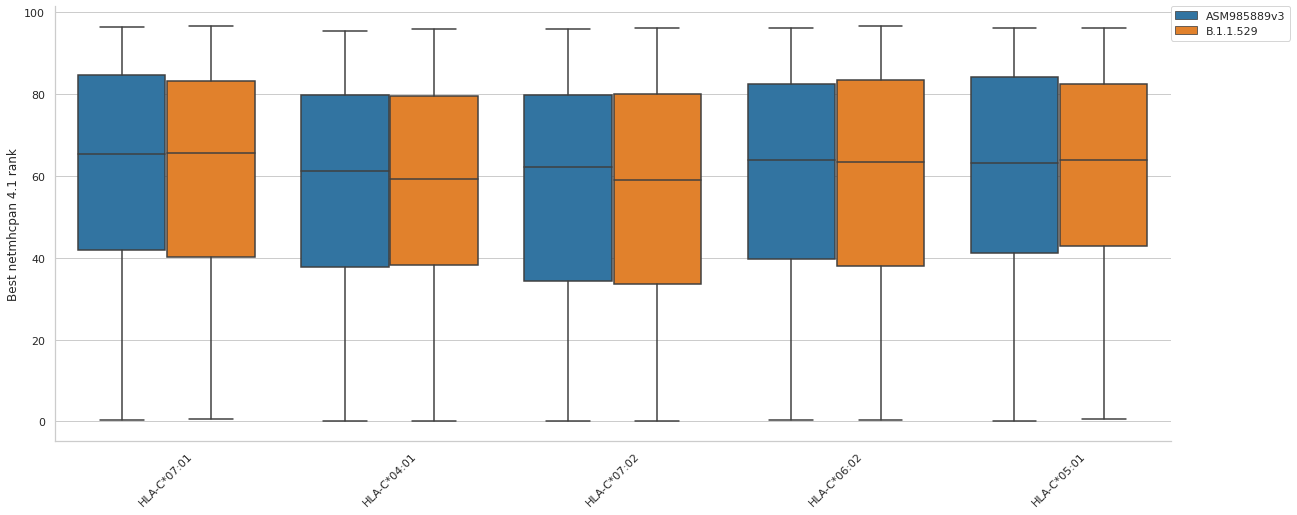

In [170]:
data = omicron_mhc_binding_europe.set_index(["epitope", "homologous_epitope", "hla_allele"])
data.columns.name = 'var_name'
data = data.stack()
data.name = 'value'
data = data.reset_index()
data.var_name = data.var_name.transform(
    lambda x: "ASM985889v3" if x == "mhc_binding" else "B.1.1.529")
data["gene"] = data.hla_allele.transform(lambda x: x[0:5])


def plot_boxplot(data, figname):
    fig = plt.figure(figsize=(20,8))
    sns.boxplot(data=data, y="value", x="hla_allele", hue="var_name")
    plt.legend()
    plt.xlabel(None)
    plt.ylabel("Best netmhcpan 4.1 rank")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.)
    sns.despine()
    fig.savefig(figname)
    
plot_boxplot(data=data[data.gene == "HLA-A"], figname="figure_boxplot_omicron_europe_hla_a.png")
plot_boxplot(data=data[data.gene == "HLA-B"], figname="figure_boxplot_omicron_europe_hla_b.png")
plot_boxplot(data=data[data.gene == "HLA-C"], figname="figure_boxplot_omicron_europe_hla_c.png")

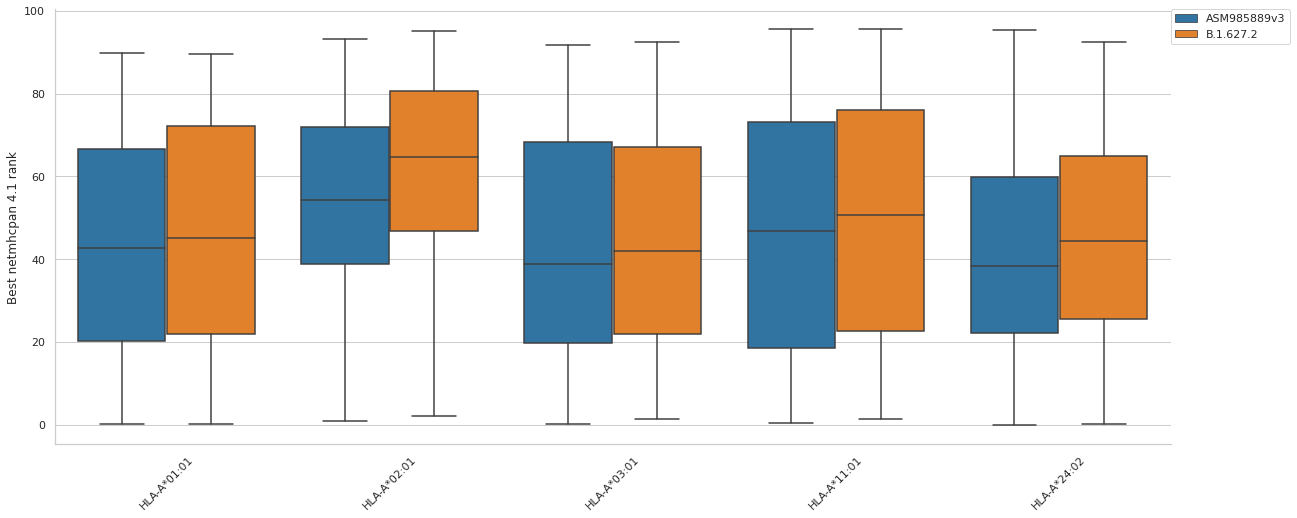

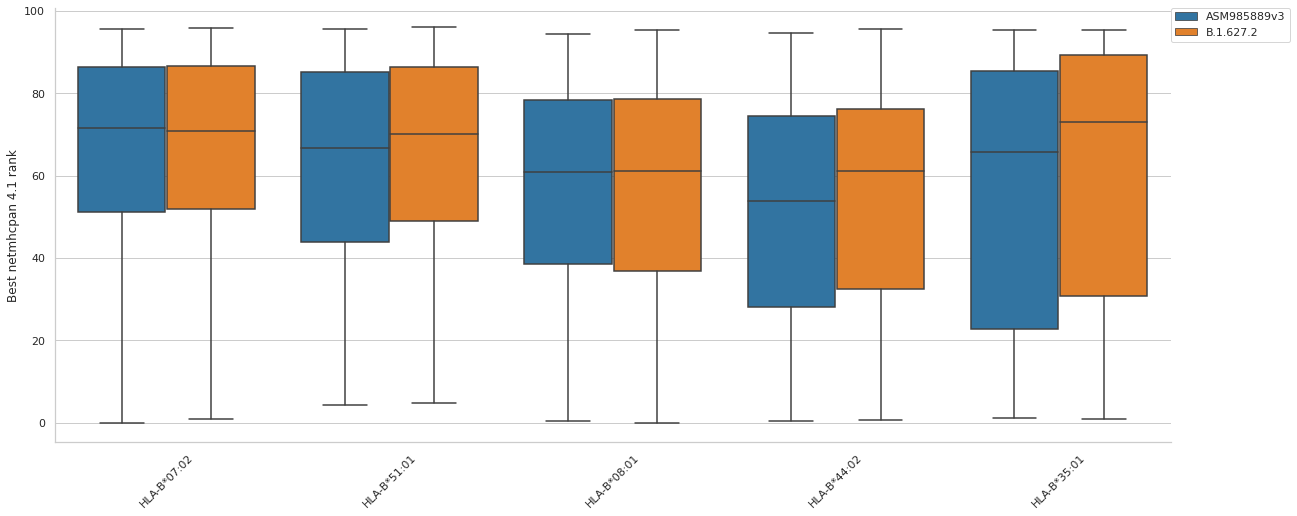

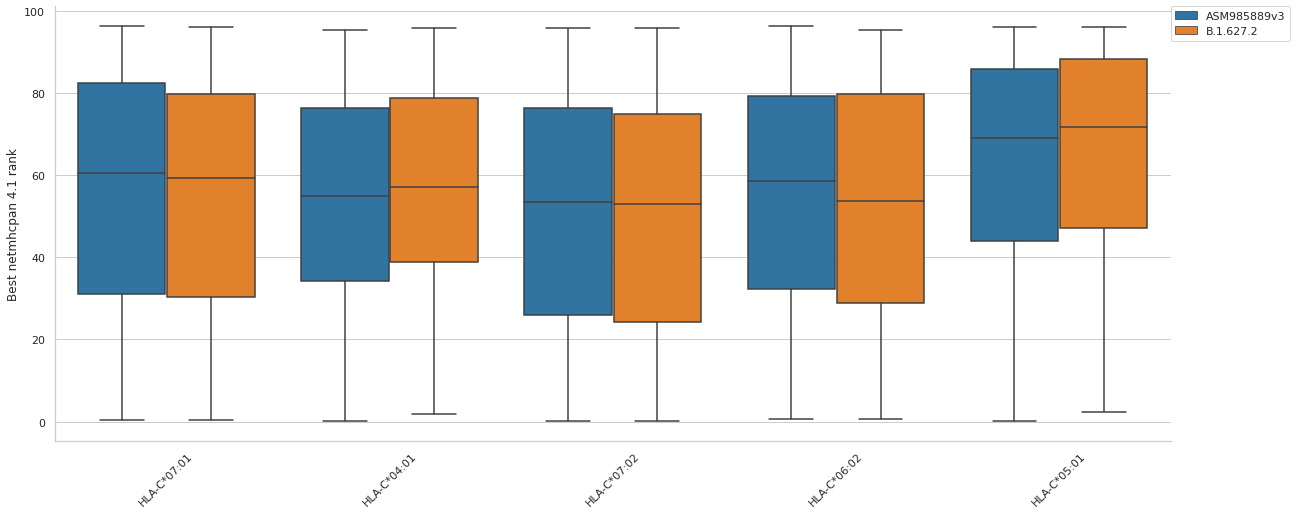

In [171]:
data = delta_mhc_binding_europe.set_index(["epitope", "homologous_epitope", "hla_allele"])
data.columns.name = 'var_name'
data = data.stack()
data.name = 'value'
data = data.reset_index()
data.var_name = data.var_name.transform(
    lambda x: "ASM985889v3" if x == "mhc_binding" else "B.1.627.2")
data["gene"] = data.hla_allele.transform(lambda x: x[0:5])

plot_boxplot(data=data[data.gene == "HLA-A"], figname="figure_boxplot_delta_europe_hla_a.png")
plot_boxplot(data=data[data.gene == "HLA-B"], figname="figure_boxplot_delta_europe_hla_b.png")
plot_boxplot(data=data[data.gene == "HLA-C"], figname="figure_boxplot_delta_europe_hla_c.png")

In [172]:
omicron_mhc_binding_europe["quotient_mhc_binding"] = omicron_mhc_binding_europe.mhc_binding / omicron_mhc_binding_europe.homologous_mhc_binding
omicron_mhc_binding_europe.head()

,epitope,homologous_epitope,hla_allele,mhc_binding,homologous_mhc_binding,quotient_mhc_binding
8,GSFCTQLNR,GSFCTQLKR,HLA-A*01:01,10.983000,9.494000,1.156836
19,LQDVVNQNAQALNTL,LQDVVNHNAQALNTL,HLA-A*01:01,32.622002,30.802999,1.059053
35,SVLNDILSR,SVLNDIFSR,HLA-A*01:01,40.101002,40.721001,0.984774
38,VLNDILSRL,VLNDIFSRL,HLA-A*01:01,12.277000,9.082000,1.351795
44,FPNITNLCPFGEVFN,FPNITNLCPFDEVFN,HLA-A*01:01,41.508999,41.560001,0.998773


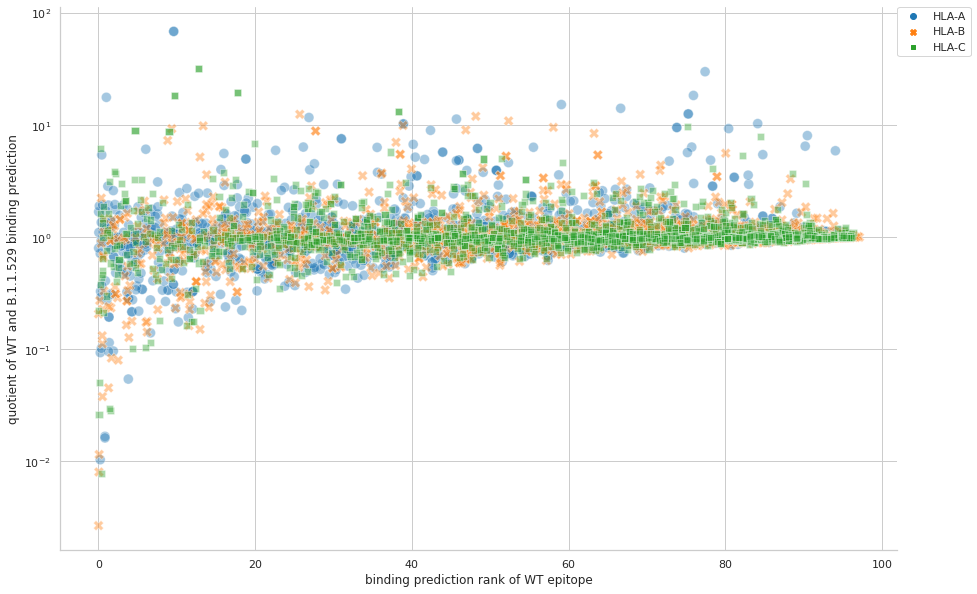

In [173]:
#omicron_mhc_binding_europe.reset_index(inplace=True)
omicron_mhc_binding_europe["gene"] = omicron_mhc_binding_europe.hla_allele.transform(lambda x: x[0:5])
fig = plt.figure(figsize=(15,10))
sns.scatterplot(data=omicron_mhc_binding_europe, 
                x="mhc_binding", y="quotient_mhc_binding", style="gene", hue="gene", s=100, alpha=0.4)
plt.yscale('log')
plt.xlabel("binding prediction rank of WT epitope")
plt.ylabel("quotient of WT and B.1.1.529 binding prediction")
plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig("figure_scatterplot_omicron_europe.png")

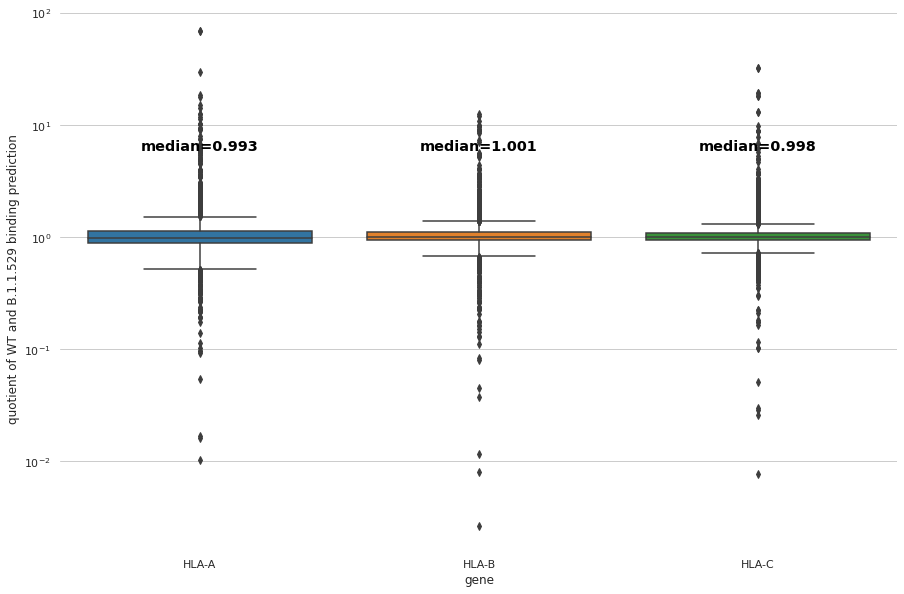

In [174]:
fig = plt.figure(figsize=(15,10))
box_plot = sns.boxplot(data=omicron_mhc_binding_europe, x="gene", y="quotient_mhc_binding")

medians = omicron_mhc_binding_europe.groupby(['gene'])['quotient_mhc_binding'].median()
vertical_offset = omicron_mhc_binding_europe['quotient_mhc_binding'].median() * 5.00 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset, "median={:.3f}".format(medians[xtick]), 
            horizontalalignment='center',size='large',color='black',weight='semibold')

plt.yscale('log')
plt.ylabel("quotient of WT and B.1.1.529 binding prediction")
sns.despine(bottom=True, left=True)
fig.savefig("figure_boxplot_omicron_europe_quotient.png")

In [175]:
delta_mhc_binding_europe["quotient_mhc_binding"] = delta_mhc_binding_europe.mhc_binding / delta_mhc_binding_europe.homologous_mhc_binding
delta_mhc_binding_europe.head()

,epitope,homologous_epitope,hla_allele,mhc_binding,homologous_mhc_binding,quotient_mhc_binding
19,LQDVVNQNAQALNTL,LQNVVNQNAQALNTL,HLA-A*01:01,32.622002,52.330002,0.623390
82,VGGNYNYLYRLFRKS,VGGNYNYRYRLFRKS,HLA-A*01:01,65.877998,73.568001,0.895471
85,YLYRLFRKSNLKPFE,YRYRLFRKSNLKPFE,HLA-A*01:01,46.111000,70.663002,0.652548
88,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVAS,AGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSRRRARSVAS,HLA-A*01:01,88.605003,89.011002,0.995439
100,FCNDPFLGVYY,FCNDPFLDVYY,HLA-A*01:01,1.019000,1.024000,0.995117


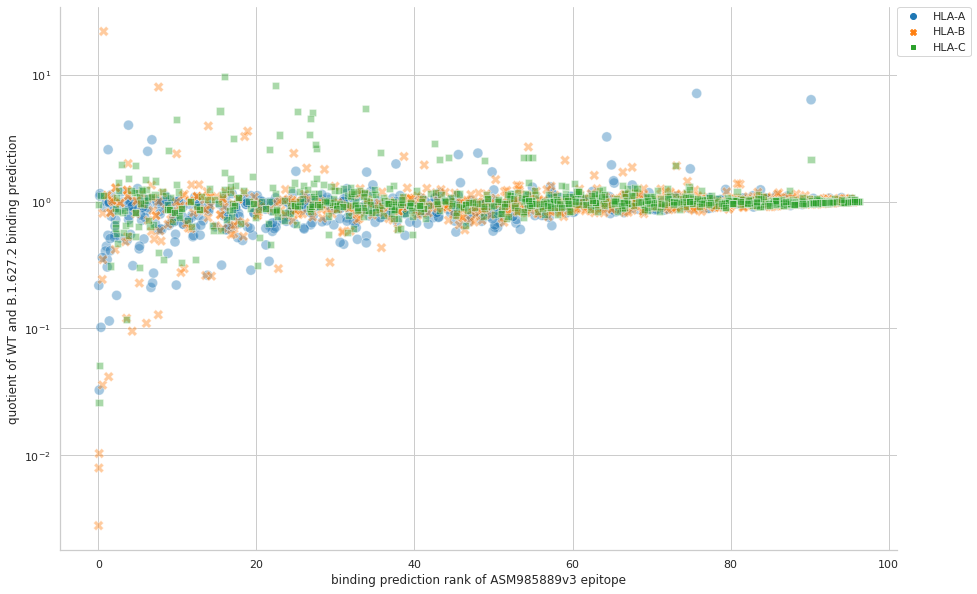

In [176]:
#omicron_mhc_binding_europe.reset_index(inplace=True)
delta_mhc_binding_europe["gene"] = delta_mhc_binding_europe.hla_allele.transform(lambda x: x[0:5])
fig = plt.figure(figsize=(15,10))
sns.scatterplot(data=delta_mhc_binding_europe, 
                x="mhc_binding", y="quotient_mhc_binding", style="gene", hue="gene", s=100, alpha=0.4)
plt.yscale('log')
plt.xlabel("binding prediction rank of ASM985889v3 epitope")
plt.ylabel("quotient of WT and B.1.627.2 binding prediction")
plt.legend(bbox_to_anchor=(1.00, 1), loc=2, borderaxespad=0.)
sns.despine()
fig.savefig("figure_scatterplot_delta_europe.png")

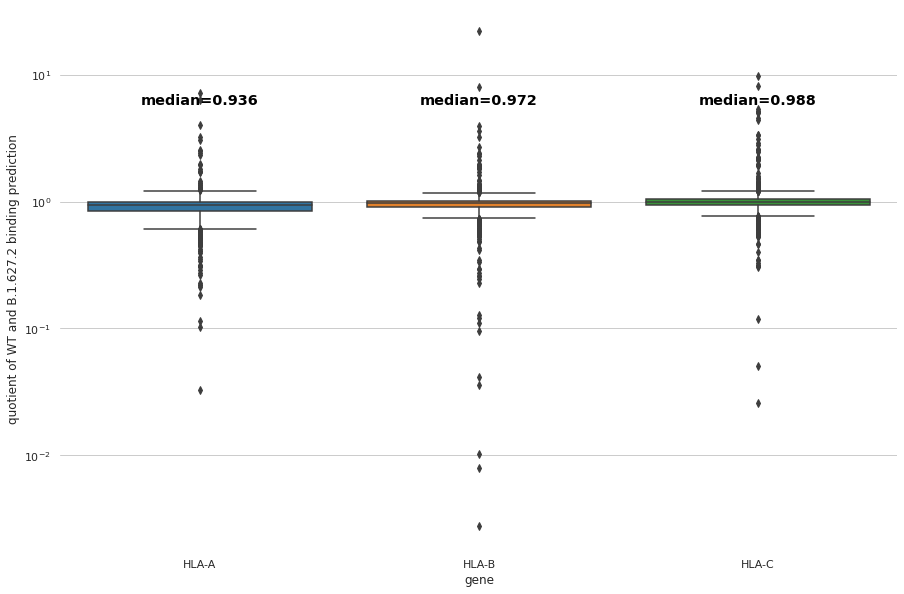

In [177]:
fig = plt.figure(figsize=(15,10))
box_plot = sns.boxplot(data=delta_mhc_binding_europe, x="gene", y="quotient_mhc_binding")

medians = delta_mhc_binding_europe.groupby(['gene'])['quotient_mhc_binding'].median()
vertical_offset = delta_mhc_binding_europe['quotient_mhc_binding'].median() * 5 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset, "median={:.3f}".format(medians[xtick]), 
            horizontalalignment='center',size='large',color='black',weight='semibold')

plt.yscale('log')
plt.ylabel("quotient of WT and B.1.627.2 binding prediction")
sns.despine(bottom=True, left=True)
fig.savefig("figure_boxplot_delta_europe_quotient.png")